# Visualize RadonEye log file data

List all available files in the directory.

In [1]:
ls -al

total 164
drwxrwxrwx 1 1000 1000  4096 Apr  1 09:57  ./
drwxr-xr-x 1 root root  4096 Apr  1 17:00  ../
drwxrwxrwx 1 1000 1000  4096 Jan  1 20:14  .devcontainer/
-rwxrwxrwx 1 1000 1000   129 Apr  1 16:56  .env*
drwxrwxrwx 1 1000 1000  4096 Jan  1 21:25  .git/
-rwxrwxrwx 1 1000 1000    20 Jan  1 21:08  .gitignore*
drwxrwxrwx 1 1000 1000  4096 Jan  1 21:13  .ipynb_checkpoints/
drwxrwxrwx 1 1000 1000  4096 Nov 26 15:54  .vscode/
-rwxrwxrwx 1 1000 1000  6053 Apr  1 17:30  EvaluateLog.ipynb*
-rwxrwxrwx 1 1000 1000 15228 Apr  1  2021 'RE22002111054_20210301 100921.txt'*
-rwxrwxrwx 1 1000 1000  1367 Jan  1 21:23  README.md*
-rwxrwxrwx 1 1000 1000 69884 Apr  1 17:29  boxplot.svg*
drwxrwxrwx 1 1000 1000  4096 Apr  1 10:05  docker/
-rwxrwxrwx 1 1000 1000   457 Apr  1 17:00  docker-compose.yml*
-rwxrwxrwx 1 1000 1000 59841 Apr  1 17:30  lineplot.svg*


Import all required libraries.

In [2]:
import pandas as pd
import numpy as np
import re
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from IPython.display import display

Define regular expression for filtering for log files within the directory. Log file names created by FTLab Radon Eye are named in the following way:<br>
- example: 'RE22002111054_20210301 100921.txt' which relates to `<serial no>_<YYmmDD> <HHMMSS>.txt`

In [3]:
# filter for log files using regex for log file name
pat_file = re.compile('(RE[0-9]+)_([0-9]+ [0-9]+).txt')
files = []
matches = []
for f in os.listdir('.'):
    m=re.match(pat_file,f)
    if m is not None:
        files.append(f)
        matches.append(m)

# print info from retrieved files
for (f, m) in zip(files, matches):
    sn = m.group(1)
    date_time_obj = datetime.strptime(m.group(2), '%Y%m%d %H%M%S')
    print(f"file name: '{f}', serial No: '{sn}', date time: '{date_time_obj}'")


file name: 'RE22002111054_20210301 100921.txt', serial No: 'RE22002111054', date time: '2021-03-01 10:09:21'


## Analyzing the log file
Read first file found (here in this repository, only one log file is available).

In [4]:
# selecting the first file
file = files[0]
df = pd.read_csv(f, sep='\t')
display(df)

,FTLab Radon Data
Model Name:,Radon Eye
S/N:,RE22002111054
Unit:,Bq/m3
Time step:,1hour
Data No:,1576
...,...
1572),8
1573),8
1574),29
1575),71


Check dataframe head for more information.

In [5]:
display(df.head(8))

,FTLab Radon Data
Model Name:,Radon Eye
S/N:,RE22002111054
Unit:,Bq/m3
Time step:,1hour
Data No:,1576
1),48
2),43
3),42


Get the number of measurements from field `Data No:`.

In [6]:
# number of measurements
num = int(df.loc['Data No:'].values[0])
print(f"Number of measurements: '{num}'")

Number of measurements: '1576'


## Retrieving rows that contain measurment values
Get all indices that contain measurement values. Measurement values are indicated by index column values like: <br>
`1), 2), ...`

A regular expression is used for retrieving the rows with measurement values.

In [7]:
# regex for index column, indicating measurement value rows
re_step = '([0-9]+)\\)'

#index_step = df.index.str.contains(re_step, regex=True)
index_step = df.index.str.extract(re_step).dropna().index
display(index_step) 

Int64Index([   5,    6,    7,    8,    9,   10,   11,   12,   13,   14,
            ...
            1571, 1572, 1573, 1574, 1575, 1576, 1577, 1578, 1579, 1580],
           dtype='int64', length=1576)

## Setting the date time for each entry
File name containing data time is created on export and will there for correspond with data time of last measurement value.

In [16]:
df['date_time'] = np.nan
df_ = df.iloc[index_step,:]
df_ = df_.astype({'FTLab Radon Data':'int'})
for i, (index, row) in enumerate(df_.iterrows()):
    date_time = date_time_obj-timedelta(hours=num-1-i)
    df_.loc[index,'date_time'] = date_time
df_

,FTLab Radon Data,date_time
1),48,2020-12-25 19:09:21
2),43,2020-12-25 20:09:21
3),42,2020-12-25 21:09:21
4),59,2020-12-25 22:09:21
5),45,2020-12-25 23:09:21
...,...,...
1572),8,2021-03-01 06:09:21
1573),8,2021-03-01 07:09:21
1574),29,2021-03-01 08:09:21
1575),71,2021-03-01 09:09:21


## Plot Radon levels
Line plot displaying all values (one per hour).

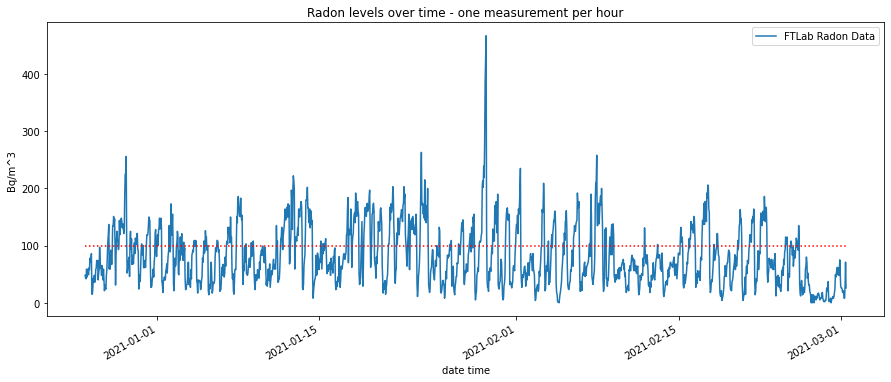

In [40]:
fig, ax = plt.subplots(figsize=(15,6))
df_.plot.line(
    y='FTLab Radon Data',
    x='date_time',
    ax=ax, grid=False)
ax.hlines(
    y=100, 
    xmin=df_['date_time'].values[0], 
    xmax=df_['date_time'].values[-1], 
    linestyle=':', color='r')
ax.set_xlabel("date time")
ax.set_ylabel("Bq/m^3")
ax.set_title("Radon levels over time - one measurement per hour")
plt.show()

fig.savefig('plot_lineplot.svg', facecolor='white', transparent=False)

Box plot grouping the measurements by the hours of the day (24h).

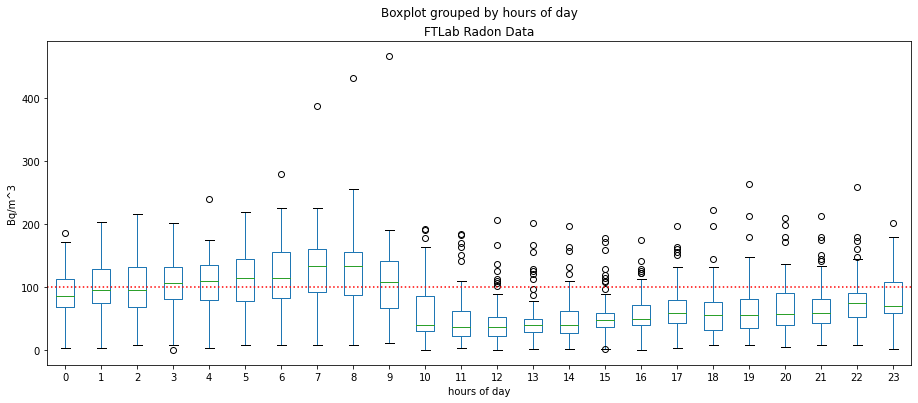

In [27]:
df_.set_index(df_.date_time, inplace=True)
df_['hours of day']= df_.index.hour

fig, ax = plt.subplots(figsize=(15,6))
df_.boxplot(by='hours of day', ax=ax, grid=False)
ax.set_xlabel("hours of day")
ax.set_ylabel("Bq/m^3")
ax.hlines(y=100, xmin=0.5, xmax=24.5, linestyle=':', color='r')
plt.show()
fig.savefig('plot_boxplot.svg', facecolor='white', transparent=False)